In [2]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow import keras

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

from scipy.optimize import curve_fit


# Dataset

In [3]:
import os
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [4]:
path = "../data/projected/"
filelist     = os.listdir(path) 
train_files  = [file for file in filelist    if "train" in file]
train_proj   = [file for file in train_files if "proj" in file]
train_target = [file for file in train_files if "targets" in file]
test_files   = [file for file in filelist    if "test" in file]
test_proj    = [file for file in test_files  if "proj" in file]
test_target  = [file for file in test_files  if "targets" in file]

train_files.sort(key=natural_keys) 
train_proj.sort(key=natural_keys)  
train_target.sort(key=natural_keys)
test_files.sort(key=natural_keys)  
test_proj.sort(key=natural_keys)   
test_target.sort(key=natural_keys) 

## Train dataset

In [6]:
mat = np.empty(shape=(0, 230, 124, 2))

for file in train_proj:
    f   = np.load(path + file)["arr_0"]
    mat = np.concatenate((mat, f), axis=0)
    
mat.shape

(34999, 230, 124, 2)

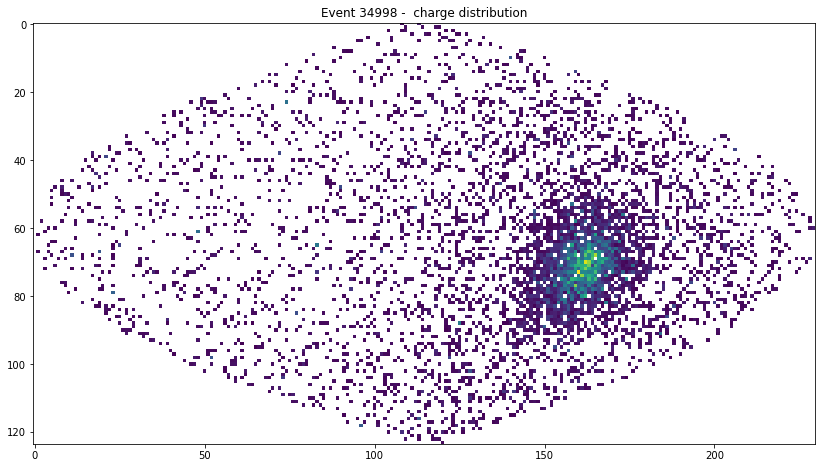

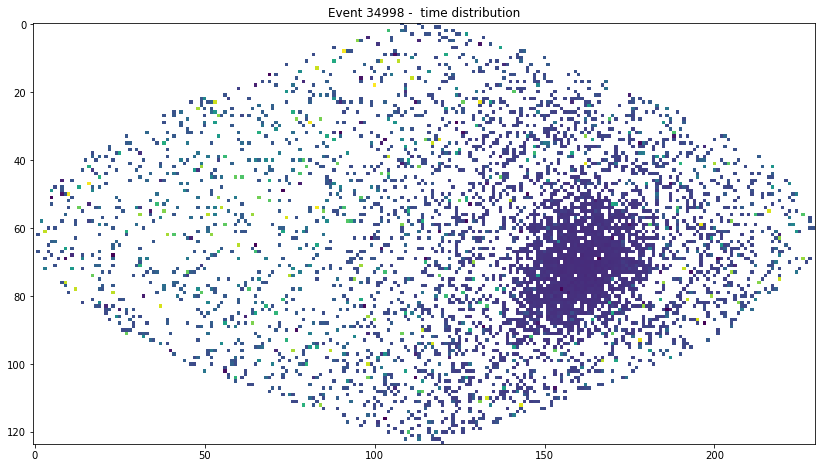

In [7]:
# event display
ev = 34998

fig = plt.figure(figsize=(14,14))
plt.title(f"Event {ev} -  charge distribution")
plt.imshow(mat[ev,:,:,0].T)
plt.show()

fig = plt.figure(figsize=(14,14))
plt.title(f"Event {ev} -  time distribution")
plt.imshow(mat[ev,:,:,1].T)
plt.show()

### VERY IMPORTANT CELL:

In [8]:
# nan to zero 
mat[np.isnan(mat)] = 0

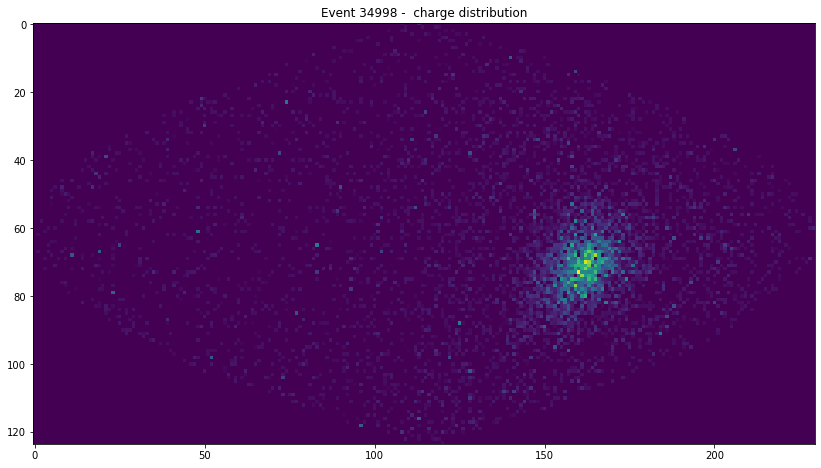

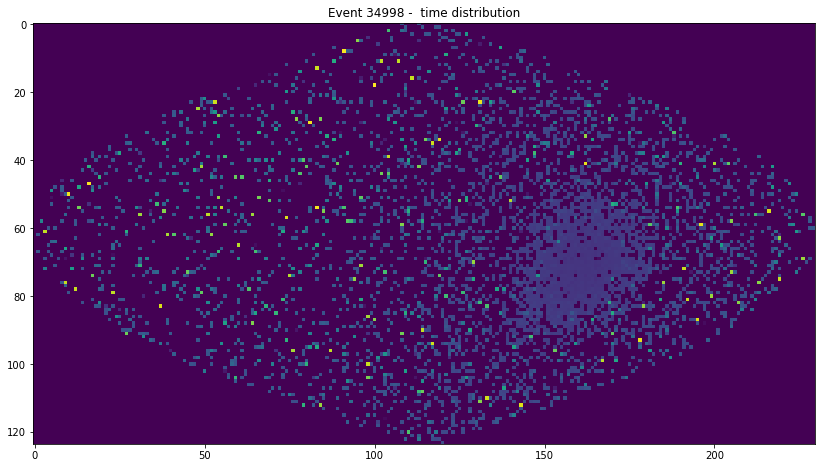

In [9]:
# event display
ev = 34998

fig = plt.figure(figsize=(14,14))
plt.title(f"Event {ev} -  charge distribution")
plt.imshow(mat[ev,:,:,0].T)
plt.show()

fig = plt.figure(figsize=(14,14))
plt.title(f"Event {ev} -  time distribution")
plt.imshow(mat[ev,:,:,1].T)
plt.show()

### Reduce image resolution

In [10]:
def conv_juno(in_matrix, kernel_size, input_shape=(230, 124)):
    """Convolves the input image to reduce size"""
    '''k_s_0 = input_shape[0] - out_shape[0]*stride[0] + 1*stride[0]
    k_s_1 = input_shape[1] - out_shape[1]*stride[1] + 1*stride[1]
    kernel_size = (k_s_0, k_s_1)'''
    stride = kernel_size

    out_shape = np.zeros(2).astype(int)
    out_shape[0] = int((input_shape[0]-kernel_size[0])/stride[0] + 1)
    out_shape[1] = int((input_shape[1]-kernel_size[1])/stride[1] + 1)
    
    out_matrix = np.zeros((out_shape[0], out_shape[1], 2))

    # Loop over the image
    for j in range(0, input_shape[0] - kernel_size[0] + 1, stride[0]):
        for k in range(0, input_shape[1] - kernel_size[1] + 1, stride[1]):
            # sum charge over the kernel
            out_matrix[j  // stride[0], k  // stride[1], 0] = np.sum(in_matrix[j:j+kernel_size[0], k:k+kernel_size[1], 0])
            # charge weighted sum of time over the kernel
            weights = in_matrix[j:j+kernel_size[0], k:k+kernel_size[1], 0]
            elements = in_matrix[j:j+kernel_size[0], k:k+kernel_size[1], 1]
            out_matrix[j  // stride[0], k  // stride[1], 1] = np.sum(np.multiply(elements, weights))/np.sum(weights) \
                                                              if np.sum(weights) != 0 else 0
    return out_matrix

In [11]:
# set kernel size
kernel_size = (4, 4)

# convolve the image
test_output_shape = conv_juno(mat[0], kernel_size=kernel_size)

# for each event, convolve the image
conv_mat = np.zeros((mat.shape[0], test_output_shape.shape[0], test_output_shape.shape[1], test_output_shape.shape[2]))
for i in range(mat.shape[0]):
    conv_mat[i] = conv_juno(mat[i], kernel_size)

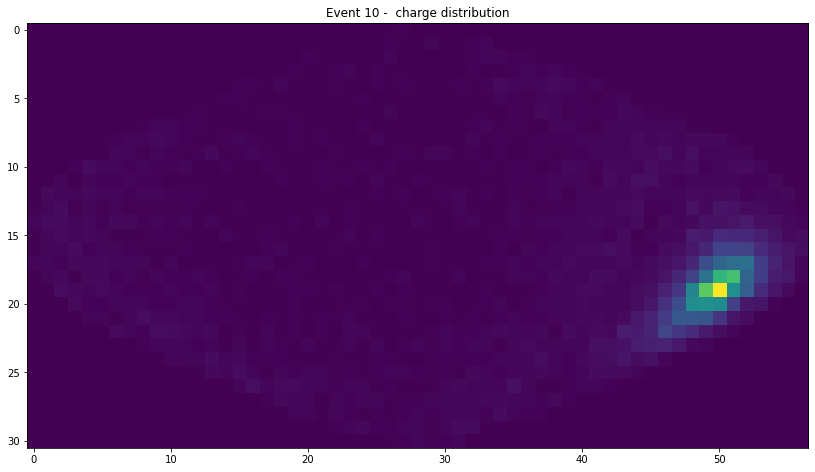

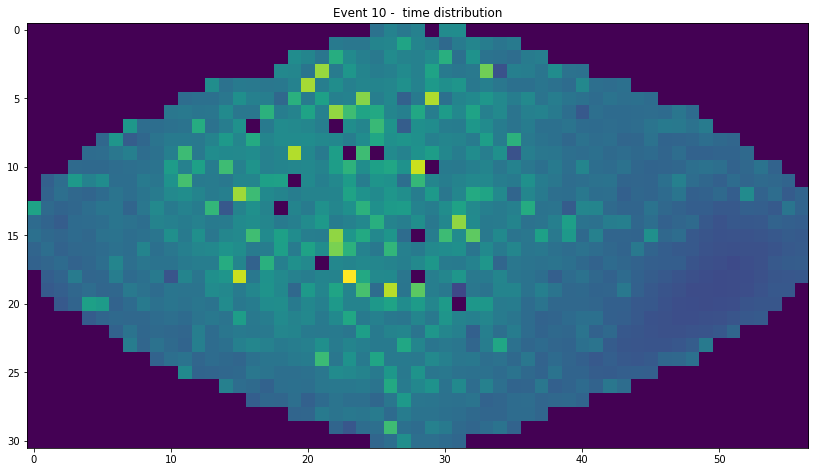

In [12]:
ev = 10

fig = plt.figure(figsize=(14,14))
plt.title(f"Event {ev} -  charge distribution")
plt.imshow(conv_mat[ev, :,:,0].T)
plt.show()
fig = plt.figure(figsize=(14,14))
plt.title(f"Event {ev} -  time distribution")
plt.imshow(conv_mat[ev, :,:,1].T)
plt.show()


## Train labels

In [13]:
train_images = conv_mat
train_images.shape

(34999, 57, 31, 2)

In [14]:
train_labels = np.empty(shape=(0))

for file in train_target:
    f   = pd.read_csv(path + file)["edep"].to_numpy()
    train_labels = np.concatenate((train_labels, f), axis=0)

train_labels.shape

(34999,)

# CNN Training

In [15]:
fig_shape = (train_images.shape[1], train_images.shape[2])
channels  = train_images.shape[3]

In [16]:
def cnn_model(
    img_size = (57, 31),
    channels = 2
):
    cnn_model = models.Sequential(
        [
            layers.Conv2D(
                filters     = 32, 
                kernel_size = 3, 
                activation  = 'relu',
                strides     = (2,2), 
                input_shape = (img_size[0], img_size[1], channels),
                data_format = 'channels_last'
            ),
            layers.MaxPool2D(pool_size=2, strides=2),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.1),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.1),
            layers.Dense(32, activation='relu'),
            layers.Dropout(0.1),
            layers.Dense(16, activation='relu'),
            layers.Dense(1, activation='linear')
        ]
    )

    cnn_model.compile(
        optimizer='adam',
        loss="mean_squared_error",
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )

    return cnn_model

In [100]:
def cnn_model_2(
    img_size = (57, 31),
    channels = 2
):
    cnn_model = models.Sequential(
        [
            layers.Conv2D(
                filters     = 32, 
                kernel_size = 3, 
                activation  = 'relu',
                strides     = (2,2), 
                input_shape = (img_size[0], img_size[1], channels),
                data_format = 'channels_last'
            ),
            # layers.BatchNormalization(),
            layers.Conv2D(
                filters     = 64, 
                kernel_size = 2, 
                activation  = 'relu',
                strides     = (2,2), 
                input_shape = (img_size[0], img_size[1], channels),
                data_format = 'channels_last'
            ),
            # layers.BatchNormalization(),
            # layers.MaxPool2D(pool_size=2, strides=2),
            layers.Flatten(),
            # layers.Dense(128, activation='relu'),
            # layers.Dropout(0.1),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.1),
            # layers.Dense(32, activation='relu'),
            # layers.Dropout(0.1),
            layers.Dense(128, activation='relu'),
            # layers.Dropout(0.1),
            # layers.Dense(32, activation='relu'),
            layers.Dense(1, activation='linear')
        ]
    )

    cnn_model.compile(
        optimizer='adam',
        loss="mean_squared_error",
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )

    return cnn_model

In [101]:
cnn = cnn_model_2(
    img_size = fig_shape,
    channels = channels
)

In [102]:
cnn.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 28, 15, 32)        608       
                                                                 
 conv2d_23 (Conv2D)          (None, 14, 7, 64)         8256      
                                                                 
 flatten_11 (Flatten)        (None, 6272)              0         
                                                                 
 dense_38 (Dense)            (None, 512)               3211776   
                                                                 
 dropout_27 (Dropout)        (None, 512)               0         
                                                                 
 dense_39 (Dense)            (None, 128)               65664     
                                                                 
 dense_40 (Dense)            (None, 1)               

In [103]:
n_epochs   = 40
batch_size = 64

cnn_history = cnn.fit(
    train_images,
    train_labels,
    validation_split = 0.1,
    batch_size       = batch_size,
    epochs           = n_epochs, 
    verbose          = 2
)

Epoch 1/40


2022-06-06 16:17:21.342700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-06 16:17:25.200050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


493/493 - 4s - loss: 1455.1158 - root_mean_squared_error: 38.1460 - val_loss: 2.6728 - val_root_mean_squared_error: 1.6349 - 4s/epoch - 9ms/step
Epoch 2/40
493/493 - 4s - loss: 4.0397 - root_mean_squared_error: 2.0099 - val_loss: 1.6102 - val_root_mean_squared_error: 1.2689 - 4s/epoch - 7ms/step
Epoch 3/40
493/493 - 4s - loss: 1.9821 - root_mean_squared_error: 1.4079 - val_loss: 0.9519 - val_root_mean_squared_error: 0.9757 - 4s/epoch - 7ms/step
Epoch 4/40
493/493 - 4s - loss: 1.3081 - root_mean_squared_error: 1.1437 - val_loss: 0.8237 - val_root_mean_squared_error: 0.9076 - 4s/epoch - 8ms/step
Epoch 5/40
493/493 - 4s - loss: 0.9706 - root_mean_squared_error: 0.9852 - val_loss: 0.4366 - val_root_mean_squared_error: 0.6607 - 4s/epoch - 9ms/step
Epoch 6/40
493/493 - 4s - loss: 0.7037 - root_mean_squared_error: 0.8389 - val_loss: 0.4906 - val_root_mean_squared_error: 0.7005 - 4s/epoch - 9ms/step
Epoch 7/40
493/493 - 4s - loss: 0.5348 - root_mean_squared_error: 0.7313 - val_loss: 0.2433 - v

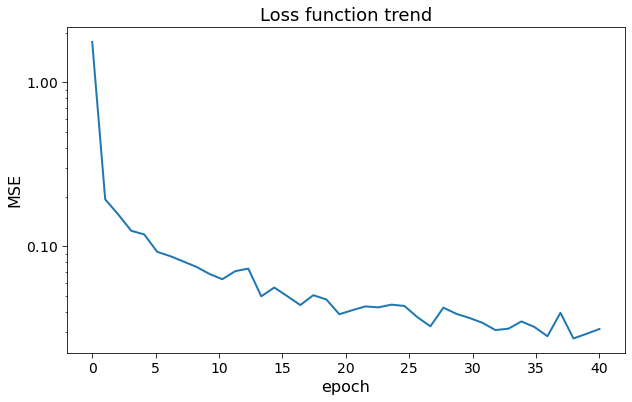

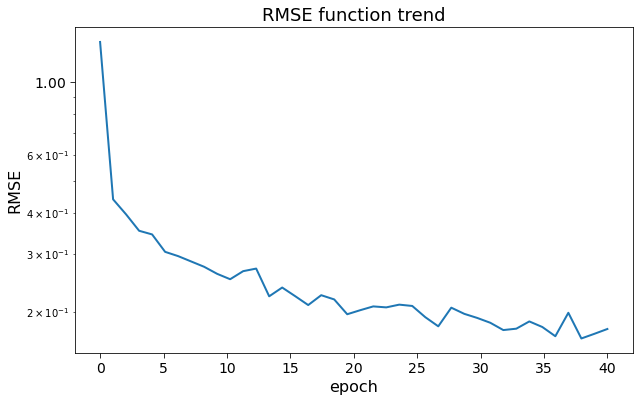

In [85]:
loss = cnn_history.history["loss"]
rmse = cnn_history.history["root_mean_squared_error"]
epochs = np.linspace(0, n_epochs, n_epochs)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(epochs, loss, lw=2)

ax.set_title("Loss function trend", fontsize=18)
ax.set_xlabel("epoch", fontsize=16)
ax.set_ylabel("MSE", fontsize=16)

ax.set_yscale("log")

ax.tick_params(axis="both", which="major", labelsize=14, length=5)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.yaxis.get_offset_text().set_fontsize(14)
# ax.ticklabel_format(axis = 'y', style = 'scientific', scilimits = (0, 0))

plt.show()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(epochs, rmse, lw=2)

ax.set_title("RMSE function trend", fontsize=18)
ax.set_xlabel("epoch", fontsize=16)
ax.set_ylabel("RMSE", fontsize=16)

ax.set_yscale("log")

ax.tick_params(axis="both", which="major", labelsize=14, length=5)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.yaxis.get_offset_text().set_fontsize(14)
# ax.ticklabel_format(axis = 'y', style = 'scientific', scilimits = (0, 0))

plt.show()


# Prediction

## Test images

In [22]:
test_images = np.empty(shape=(0, 230, 124, 2))

for file in test_proj:
    f   = np.load(path + file)["arr_0"]
    test_images = np.concatenate((test_images, f), axis=0)

# nan to zero 
test_images[np.isnan(test_images)] = 0

test_images.shape

(5000, 230, 124, 2)

## Test labels

In [23]:
test_labels = np.empty(shape=(0))

for file in test_target:
    f   = pd.read_csv(path + file)["edep"].to_numpy()
    test_labels = np.concatenate((test_labels, f), axis=0)
    
test_labels.shape

(5000,)

In [24]:
# set kernel size
kernel_size = (4, 4)

# convolve the image
test_output_shape = conv_juno(test_images[0], kernel_size=kernel_size)

# for each event, convolve the image
conv_mat = np.zeros((test_images.shape[0], test_output_shape.shape[0], test_output_shape.shape[1], test_output_shape.shape[2]))
for i in range(test_images.shape[0]):
    conv_mat[i] = conv_juno(test_images[i], kernel_size)

In [104]:
edep_pred = cnn.predict(conv_mat)
edep_pred.shape

2022-06-06 16:19:42.477971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


(5000, 1)

In [105]:
edep_pred = edep_pred.reshape(edep_pred.shape[0],)
edep_pred.shape

(5000,)

In [106]:
res = (edep_pred-test_labels)/test_labels
res = res[np.abs(res - res.mean()) < 3*res.std()]

### Gaussian fit

In [107]:
def gaus(x, a, mu, sigma):
    return a*np.exp( -(x-mu)**2 / (2*sigma**2) )

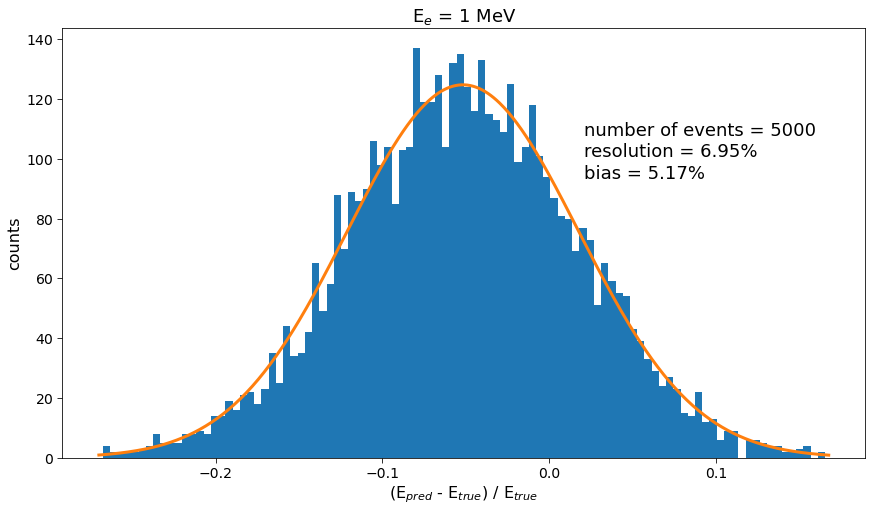

In [108]:
hist, edges = np.histogram(res, bins=100)
bincenters = (edges[1:] + edges[:-1]) / 2

xgrid = np.linspace(edges[0], edges[-1], 500)

n     = res.shape[0]
mean  = res.mean()
sigma = res.std()
popt, pcov = curve_fit(gaus, bincenters, hist, p0=[n, mean, sigma])

n_events   = edep_pred.shape[0]
resolution = popt[2]
bias       = popt[1]

fig = plt.figure(figsize=(12,7), constrained_layout=True)
ax  = fig.add_subplot(111)

ax.hist(bincenters, weights=hist, bins=100)
ax.plot(xgrid, gaus(xgrid, *popt), lw=3)
ax.text(0.65, 0.75, f"number of events = {n_events}", fontsize=18,transform=ax.transAxes)
ax.text(0.65, 0.7, f"resolution = {resolution*100:.2f}%", fontsize=18,transform=ax.transAxes)
ax.text(0.65, 0.65, f"bias = {abs(bias)*100:.2f}%", fontsize=18,transform=ax.transAxes)

ax.set_title("E$_e$ = 1 MeV", fontsize=18)
ax.set_xlabel("(E$_{pred}$ - E$_{true}$) / E$_{true}$", fontsize=16)
ax.set_ylabel("counts", fontsize=16)


# ax.set_yscale("log")

ax.tick_params(axis="both", which="major", labelsize=14, length=5)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.yaxis.get_offset_text().set_fontsize(14)

fig.savefig("./plots/e_1mev_hist_cnn9.png", dpi=300, facecolor="white")

plt.show()